In [208]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from utils import autoparse_year
import igraph as ig

In [9]:
from scipy import stats
from scipy.stats import t

In [10]:
from typing import Callable

def bootstrap(
	x: np.ndarray,
	alpha: float = 0.95,
	n: int = 1000,
	agg: Callable[[np.ndarray], float] = np.mean
):
	"""Compute confidence interval of a given data aggregate

	Parameters
	----------
	x : np.ndarray
		data
	alpha : float, optional
		size of the confidence interval, by default 0.95
	n : int, optional
		number of resamples, by default 1_000
	agg : Callable[[np.ndarray], float], optional
		aggregation function, by default np.mean

	Returns
	-------
	low, high : tuple[float, float]
		lower and higher confidence levels
	"""

	aggs = np.zeros(n)

	for i in range(n):
		sample = x[np.random.randint(0, len(x), len(x))]  # resample data uniformly
		aggs[i] = agg(sample)

	delta = (1-alpha)/2
	return np.percentile(aggs, 100*delta), np.percentile(aggs, 100*(1-delta))

In [251]:
df_edges = pd.read_pickle('../data/generated/graph/actor_graph_full.grouped.pkl')
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

In [252]:
x=df_edges.rename(columns={"actor2_fbid": "actor1_fbid","actor1_fbid": "actor2_fbid"})
df_edges= pd.concat([df_edges, x])
df_edges

,actor1_fbid,actor2_fbid,movie_count
503641,/m/02cvp8,/m/02t0n9,219
503751,/m/02cvp8,/m/045g4l,119
655469,/m/02t0n9,/m/045g4l,119
906958,/m/03mv0b,/m/0lh0c,101
503672,/m/02cvp8,/m/030dx5,82
...,...,...,...
717944,/m/09t0l3,/m/02z28y7,1
717943,/m/09rxk8z,/m/02z28y7,1
717942,/m/09rvxt5,/m/02z28y7,1
717941,/m/09q3gc,/m/02z28y7,1


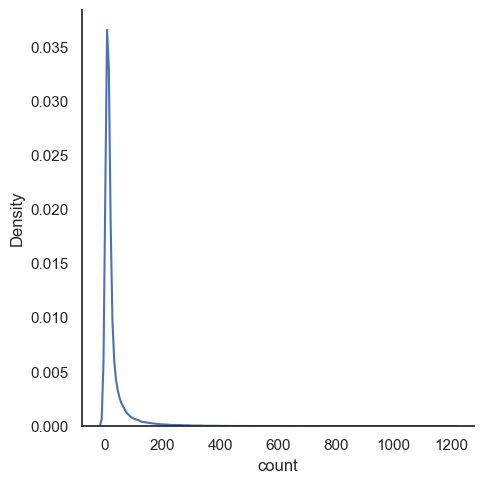

In [253]:
test =df_edges.groupby('actor1_fbid')['actor2_fbid'].agg(['count']).sort_values(by='count')
test2 = test[test['count'] > 3]
sns.displot(test, x="count", kind="kde")

In [254]:
df_edges= df_edges[df_edges.apply(lambda x: True if test.loc[x.actor1_fbid]['count']> 15 else False, axis =1)]

In [255]:
df_actors['year_of_birth'] = df_actors.actor_birth.apply(autoparse_year).astype('Int64')
df_actors=df_actors.rename(columns={"fb_actor_id": "actor1_fbid"})
df_actors

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,actor1_fbid,actor_name,actor_birth,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
1,24767455,/m/0809s7n,2009-10-16,Captain Diaz,51.0,/m/08d9z0b,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
2,5337169,/m/0dg7mt,2001,NaN,42.0,/m/04htxdc,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
3,1330220,/m/04t8wq,1990-06-22,NaN,31.0,/m/0cg7kl2,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
4,14686017,/m/03gt21w,1990-01-12,NaN,31.0,/m/09j0r8t,/m/03wcfv7,Wanda De Jesus,1958-08-26,NaN,1.62,F,United States of America,1958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Additional Voices,38.0,/m/0kr405f,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN,1954
450665,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,38.0,/m/0kr407w,/m/0gn4bz,Sonny Byrkett,1954,NaN,NaN,M,NaN,1954
450666,913762,/m/03pcrp,1992-05-21,Silvie Gena,34.0,/m/0kr40b9,/m/0gn4nd,Susan Byrkett,1958,NaN,NaN,F,NaN,1958
450667,913762,/m/03pcrp,1992-05-21,Exegran,NaN,/m/0kr407c,/m/0kr407h,Hal Cleaveland,NaN,NaN,NaN,M,NaN,<NA>


In [256]:
df_actors_reduced= df_actors.drop_duplicates(subset= 'actor1_fbid')
df_actors_reduced= df_actors_reduced.drop(['wiki_id','fb_movie_id','release','character_name','fb_char_id','actor_birth'], axis=1)
group_by_degree = df_edges.groupby('actor1_fbid')['actor2_fbid'].agg(['count'])
df_degree = pd.DataFrame({'actor_degree': list(group_by_degree['count']), 'actor1_fbid': group_by_degree.index})

df_actors_reduced= df_actors_reduced.merge(df_degree, on= 'actor1_fbid')

In [257]:
df_actors_reduced= pd.merge(df_actors_reduced, (df_actors.groupby('actor1_fbid').apply(lambda x: pd.Series({
        'number_of_movies': x['wiki_id'].count()
    }))),on='actor1_fbid')

In [222]:
df_actors_reduced

,actor_age,actor1_fbid,actor_name,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth,actor_degree,number_of_movies
0,42.0,/m/03wcfv7,Wanda De Jesus,NaN,1.620,F,United States of America,1958,110,8
1,27.0,/m/0346l4,Natasha Henstridge,NaN,1.780,F,Canada,1974,194,23
2,32.0,/m/01vw26l,Ice Cube,NaN,1.727,M,United States of America,1969,339,33
3,33.0,/m/034hyc,Jason Statham,NaN,1.750,M,United Kingdom,1967,368,31
4,23.0,/m/01y9xg,Clea DuVall,NaN,1.650,F,United States of America,1977,402,31
...,...,...,...,...,...,...,...,...,...,...
57696,NaN,/m/05srl9m,Alan Mitchell,NaN,NaN,M,NaN,<NA>,17,1
57697,NaN,/m/05srlb5,Jeff Hall,NaN,NaN,M,NaN,<NA>,17,1
57698,NaN,/m/0gcyfwt,Susan Bain,NaN,NaN,F,NaN,<NA>,17,1
57699,NaN,/m/0ghvq0_,Lincoln Ward,NaN,NaN,M,NaN,<NA>,17,1


In [223]:
x=df_edges.merge(df_actors_reduced, on='actor1_fbid')
x

,actor1_fbid,actor2_fbid,movie_count,actor_age,actor_name,ethnicity,actor_height,actor_gender,actor_nationality,year_of_birth,actor_degree,number_of_movies
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,396,225
1,/m/02cvp8,/m/045g4l,119,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,396,225
2,/m/02cvp8,/m/030dx5,82,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,396,225
3,/m/02cvp8,/m/09gx1x,40,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,396,225
4,/m/02cvp8,/m/02z023s,40,NaN,Moe Howard,NaN,1.62,M,United States of America,1897,396,225
...,...,...,...,...,...,...,...,...,...,...,...,...
3422990,/m/0cv8dwz,/m/0cv8dv2,1,NaN,Juergen Moeller,NaN,NaN,M,NaN,<NA>,20,1
3422991,/m/0cv8dwz,/m/0cv8dvg,1,NaN,Juergen Moeller,NaN,NaN,M,NaN,<NA>,20,1
3422992,/m/0cv8dwz,/m/0cv8dvc,1,NaN,Juergen Moeller,NaN,NaN,M,NaN,<NA>,20,1
3422993,/m/0cv8dwz,/m/0cv8dtx,1,NaN,Juergen Moeller,NaN,NaN,M,NaN,<NA>,20,1


In [224]:
df_actors_reduced=df_actors_reduced.rename(columns={"actor1_fbid": "actor2_fbid"})
df_edges_merged= x.merge(df_actors_reduced, on='actor2_fbid')

In [225]:
df_edges_merged

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,...,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,actor_degree_y,number_of_movies_y
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,...,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,...,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,...,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,...,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,...,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036589,/m/0crc1n7,/m/02y_r9n,3,28.0,S. Shamsuddin,NaN,NaN,M,Singapore,1929,...,5,60.0,Aziz Sattar,NaN,NaN,M,Malaysia,1925,17,7
3036590,/m/02f27,/m/0gcb2b4,1,61.0,Dirk Benedict,NaN,1.800,M,United States of America,1945,...,16,NaN,Eike Becker,NaN,NaN,M,NaN,<NA>,19,2
3036591,/m/03qp512,/m/02pyhqk,1,27.0,Peter Lee Lawrence,NaN,NaN,M,West Germany,1945,...,5,29.0,Steve Sipek,NaN,NaN,M,Canada,1942,16,2
3036592,/m/03cx_n5,/m/0gc6ycx,1,NaN,Joel Hoffman,NaN,NaN,M,NaN,<NA>,...,3,NaN,Courtney Lercara,NaN,NaN,F,NaN,<NA>,18,2


In [226]:
df_edges_age=df_edges_merged.dropna(subset=['actor_age_x'])
df_edges_age=df_edges_age.dropna(subset=['actor_age_y'])

#df_edges_red=df_edges_red.dropna(subset=['actor_height_x'])
#df_edges_red=df_edges_red.dropna(subset=['actor_height_y'])
df_edges_gender=df_edges_merged.dropna(subset=['actor_gender_x'])
df_edges_gender=df_edges_gender.dropna(subset=['actor_gender_y'])

df_edges_nat=df_edges_merged.dropna(subset=['actor_nationality_x'])
df_edges_nat=df_edges_nat.dropna(subset=['actor_nationality_y'])

df_edges_birth=df_edges_merged.dropna(subset=['year_of_birth_x'])
df_edges_birth=df_edges_birth.dropna(subset=['year_of_birth_y'])
df_edges_birth=df_edges_birth[df_edges_birth['year_of_birth_x']>1800]



print(len(df_edges_age),len(df_edges_gender),len(df_edges_nat),len(df_edges_birth))

1679212 2759840 2133664 2121965


In [227]:
homophily = {}

In [64]:
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_x'] < 2022]
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_y'] < 2022]
max_birth_date=max(df_edges_birth.year_of_birth_x)
min_birth_date=min(df_edges_birth.year_of_birth_x)
df_edges_birth['homophily_age'] = df_edges_birth.apply(lambda x: (1- abs(x.year_of_birth_x-x.year_of_birth_y)*2/90) if abs(x.year_of_birth_x-x.year_of_birth_y) < 90 else -1, axis= 1)
df_edges_birth

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,homophily_age
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.888889
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.844444
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.822222
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.844444
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.977778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422974,/m/0lzx1,/m/0ly_5,1,28.0,Susana Giménez,Hispanic and Latino Americans,NaN,F,NaN,1945,3,35.0,Carlos Monzón,NaN,1.8100,M,Argentina,1942,2,0.933333
3422984,/m/0kt7j2,/m/0j6qllg,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,36.0,Mikko Reitala,NaN,NaN,M,Finland,1964,1,0.955556
3422986,/m/0kt7j2,/m/0j6qk6g,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,18.0,Elena Leeve,NaN,NaN,F,Finland,1983,1,0.533333
3422991,/m/0kt7j2,/m/0ck5kjw,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,22.0,Lauri Nurkse,NaN,NaN,M,Finland,1978,1,0.644444


In [177]:
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_x'] < 2022]
df_edges_birth= df_edges_birth[df_edges_birth['year_of_birth_y'] < 2022]
max_birth_date=max(df_edges_birth.year_of_birth_x)
min_birth_date=min(df_edges_birth.year_of_birth_x)
df_edges_birth['homophily_age'] = df_edges_birth.apply(lambda x: np.exp(-(0.01*abs(x.year_of_birth_x-x.year_of_birth_y)-np.log(2)))-1, axis= 1)
df_edges_birth

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,homophily_age
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.902459
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.864788
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.846233
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.864788
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.980100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422974,/m/0lzx1,/m/0ly_5,1,28.0,Susana Giménez,Hispanic and Latino Americans,NaN,F,NaN,1945,3,35.0,Carlos Monzón,NaN,1.8100,M,Argentina,1942,2,0.940891
3422984,/m/0kt7j2,/m/0j6qllg,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,36.0,Mikko Reitala,NaN,NaN,M,Finland,1964,1,0.960397
3422986,/m/0kt7j2,/m/0j6qk6g,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,18.0,Elena Leeve,NaN,NaN,F,Finland,1983,1,0.621168
3422991,/m/0kt7j2,/m/0ck5kjw,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,22.0,Lauri Nurkse,NaN,NaN,M,Finland,1978,1,0.704288


In [187]:
age_homophily = df_edges_birth.groupby('actor1_fbid')['homophily_age'].agg(['mean'])
print('mean =',age_homophily.mean(), 'and std =', age_homophily.std())
homophily['age']= {
		'mean': float(age_homophily.mean()),
		'std': float(age_homophily.std())
	}

mean = mean    0.73
dtype: float64 and std = mean    0.091381
dtype: float64


In [29]:
bootstrap(age_homophily.to_numpy())

(0.6575411126795124, 0.6607944902283441)

In [30]:
edges_height=df_edges_merged.dropna(subset=['actor_height_x'])
edges_height= edges_height.dropna(subset=['actor_height_y'])
edges_height=edges_height[edges_height['actor_height_x']<3]
edges_height=edges_height[edges_height['actor_height_y']<3]
max_height= max(edges_height.actor_height_x)
min_height = min(edges_height.actor_height_x)
edges_height['homophily_height'] = edges_height.apply(lambda x: (1- 2*abs(x.actor_height_x-x.actor_height_y)/(max_height-min_height)), axis= 1)
edges_height

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,homophily_height
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.993412
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.970118
8,/m/02z475f,/m/02t0n9,24,NaN,Al Thompson,NaN,1.700,M,United States of America,1884,25,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.912471
17,/m/03mdp_b,/m/02t0n9,11,NaN,Lynton Brent,NaN,1.770,M,United States of America,1897,21,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.830118
20,/m/03cv7x1,/m/02t0n9,13,35.0,Dick Curtis,NaN,1.900,M,United States of America,1902,21,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.677176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422656,/m/02nbjq,/m/09j5w7w,1,38.0,Zak Spears,NaN,1.870,M,NaN,1965,2,27.0,Chris Dano,NaN,1.8700,M,NaN,1966,1,1.000000
3422834,/m/02vr7,/m/04x20z,1,50.0,Elvis Costello,NaN,1.780,M,NaN,1954,13,49.0,Rob Bowman,NaN,1.8000,M,NaN,1960,1,0.976471
3422858,/m/0300qs,/m/0300f1,1,33.0,Scott Reeves,NaN,1.720,M,United States of America,1966,3,32.0,Melissa Reeves,NaN,1.5700,F,United States of America,1967,1,0.823529
3422893,/m/0kcv4,/m/01g562,1,35.0,Zinedine Zidane,Berbers,1.850,M,NaN,1972,5,28.0,Thierry Henry,NaN,1.8800,M,NaN,1977,1,0.964706


In [31]:
height_homophily = edges_height.groupby('actor1_fbid')['homophily_height'].agg(['mean'])
print('mean =',height_homophily.mean(), 'and std =', height_homophily.std())
homophily['height']= {
		'mean': float(height_homophily.mean()),
		'std': float(height_homophily.std())
	}

mean = mean    0.859692
dtype: float64 and std = mean    0.064517
dtype: float64


In [32]:
bootstrap(height_homophily.to_numpy())

(0.8584460371866243, 0.8609126490631828)

In [33]:
df_edges_gender['same_gender'] = df_edges_gender.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
df_edges_gender

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_gender
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422989,/m/0kt7j2,/m/0j6qk4l,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,NaN,Tommi Mujunen,NaN,NaN,M,NaN,<NA>,1,1
3422990,/m/0kt7j2,/m/0bvb2kn,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,NaN,Christian Lindblad,NaN,NaN,M,Finland,<NA>,1,1
3422991,/m/0kt7j2,/m/0ck5kjw,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,22.0,Lauri Nurkse,NaN,NaN,M,Finland,1978,1,1
3422992,/m/0kt7j2,/m/02pzqs3,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,43.0,Seppo Pääkkönen,NaN,NaN,M,Finland,1957,1,1


In [34]:
gender_homophily = df_edges_gender.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily.mean(), 'and std =', gender_homophily.std())
homophily['gender']= {
		'mean': float(gender_homophily.mean()),
		'std': float(gender_homophily.std())
	}

mean = mean    0.117744
dtype: float64 and std = mean    0.387138
dtype: float64


In [35]:
m = gender_homophily.mean() 
s = gender_homophily.std() 
dof = len(gender_homophily)-1 
confidence = 0.95
t_crit = np.abs(t.ppf((1-confidence)/2,dof))
(m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x))) 

(mean    0.117334
 dtype: float64,
 mean    0.118154
 dtype: float64)

In [36]:
bootstrap(gender_homophily.to_numpy())

(0.11421038075367462, 0.12082418897957986)

> check value for male actor and female actress indenpendantly

In [37]:
edges_gender_m = df_edges_merged[df_edges_merged['actor_gender_x'] == 'M']
edges_gender_m= edges_gender_m.dropna(subset=['actor_gender_y'])
edges_gender_m['same_gender'] = edges_gender_m.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
edges_gender_m

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_gender
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422988,/m/0kt7j2,/m/0j6qk5j,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,NaN,Tarja Heinula,NaN,NaN,F,NaN,<NA>,1,-1
3422989,/m/0kt7j2,/m/0j6qk4l,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,NaN,Tommi Mujunen,NaN,NaN,M,NaN,<NA>,1,1
3422990,/m/0kt7j2,/m/0bvb2kn,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,NaN,Christian Lindblad,NaN,NaN,M,Finland,<NA>,1,1
3422991,/m/0kt7j2,/m/0ck5kjw,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,22.0,Lauri Nurkse,NaN,NaN,M,Finland,1978,1,1


In [38]:
gender_homophily_m = edges_gender_m.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print(gender_homophily_m.mean(), gender_homophily_m.std())
homophily['gender_m']= {
		'mean': float(gender_homophily_m.mean()),
		'std': float(gender_homophily_m.std())
	}

mean    0.351775
dtype: float64 mean    0.225965
dtype: float64


In [39]:
edges_gender_f = df_edges_merged[df_edges_merged['actor_gender_x'] == 'F']
edges_gender_f= edges_gender_f.dropna(subset=['actor_gender_y'])
edges_gender_f['same_gender'] = edges_gender_f.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
edges_gender_f

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_gender
10,/m/02zbgr_,/m/02t0n9,19,NaN,Symona Boniface,NaN,NaN,F,United States of America,1894,23,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
28,/m/03gxzbc,/m/02t0n9,11,37.0,Harriette Tarler,NaN,NaN,F,United States of America,1920,12,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
35,/m/03ng17,/m/02t0n9,1,21.0,Anita Garvin,NaN,1.68,F,United States of America,1907,10,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
38,/m/026fz4v,/m/02t0n9,7,28.0,Bonnie Bonnell,NaN,NaN,F,NaN,1905,7,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
39,/m/03hn40x,/m/02t0n9,7,36.0,Dorothy Appleby,NaN,NaN,F,United States of America,1906,9,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422854,/m/02w759j,/m/0jsrrxz,1,NaN,Jajang C. Noer,NaN,NaN,F,Indonesia,1952,4,NaN,Ryen Motzek,NaN,NaN,M,NaN,<NA>,1,-1
3422960,/m/0k52v5,/m/0415tmh,1,NaN,Molly McCarthy,NaN,NaN,F,NaN,<NA>,3,34.0,Allen Baron,NaN,NaN,M,United States of America,1927,1,-1
3422963,/m/0grdnq,/m/01jw0x,1,30.0,Helena Rojo,NaN,NaN,F,Mexico,1944,5,19.0,Lucía Méndez,NaN,NaN,F,Mexico,1955,1,1
3422974,/m/0lzx1,/m/0ly_5,1,28.0,Susana Giménez,Hispanic and Latino Americans,NaN,F,NaN,1945,3,35.0,Carlos Monzón,NaN,1.8100,M,Argentina,1942,2,-1


In [40]:
gender_homophily_f = edges_gender_f.groupby('actor1_fbid')['same_gender'].agg(['mean'])
print('mean =',gender_homophily_f.mean(), 'and std =', gender_homophily_f.std())
homophily['gender_f']= {
		'mean': float(gender_homophily_f.mean()),
		'std': float(gender_homophily_f.std())
	}

mean = mean   -0.293758
dtype: float64 and std = mean    0.240799
dtype: float64


In [289]:
df_edges_nat['same_country'] = df_edges_nat.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)

In [244]:
#nbr_e = len(df_edges_nat)
#print(nbr_e)
#df_edges_nat['same_country'] = df_edges_nat.apply(lambda x: (x.movie_count - x.actor_degree_x*x.actor_degree_y/nbr_e)/x.number_of_movies_x if (x.actor_nationality_x == x.actor_nationality_y) else -(x.movie_count - x.actor_degree_x*x.actor_degree_y/(nbr_e))/x.number_of_movies_x, axis= 1)
#df_edges_nat

2133664


,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,...,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,actor_degree_y,number_of_movies_y,same_country
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,...,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219,0.973039
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,...,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219,0.899663
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,...,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219,0.689136
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,...,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219,0.845078
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,...,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219,-0.884204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036581,/m/03_2td,/m/07r6dz,1,61.0,Alan Dale,NaN,1.880,M,New Zealand,1947,...,47.0,Louise Siversen,NaN,NaN,F,Australia,1960,17,2,-0.111013
3036585,/m/0cc8xr7,/m/0bf1hy0,2,NaN,Luna Maya,NaN,NaN,F,Indonesia,1983,...,27.0,Fauzi Baadila,NaN,NaN,M,Indonesia,1979,17,2,0.666622
3036589,/m/0crc1n7,/m/02y_r9n,3,28.0,S. Shamsuddin,NaN,NaN,M,Singapore,1929,...,60.0,Aziz Sattar,NaN,NaN,M,Malaysia,1925,17,7,-0.599960
3036591,/m/03qp512,/m/02pyhqk,1,27.0,Peter Lee Lawrence,NaN,NaN,M,West Germany,1945,...,29.0,Steve Sipek,NaN,NaN,M,Canada,1942,16,2,-0.199970


In [292]:
country_homophily = df_edges_nat.groupby('actor1_fbid')['same_country'].agg(['mean'])
print('mean =',country_homophily.mean(), 'and std =', country_homophily.std())
homophily['country']= {
		'mean': float(country_homophily.mean()),
		'std': float(country_homophily.std())
	}

mean = mean    0.441165
dtype: float64 and std = mean    0.579339
dtype: float64


In [43]:
edges_nbr_movies=df_edges_merged.dropna(subset=['number_of_movies_x'])
edges_nbr_movies= edges_nbr_movies.dropna(subset=['number_of_movies_y'])
max_nbr_movies = max(edges_nbr_movies.number_of_movies_x)
min_nbr_movies = min(edges_nbr_movies.number_of_movies_x)
edges_nbr_movies['same_country'] = edges_nbr_movies.apply(lambda x: (1- 2*abs(x.number_of_movies_x -x.number_of_movies_y)/(max_nbr_movies-min_nbr_movies)), axis= 1)
edges_nbr_movies

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,number_of_movies_y,same_country
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.984810
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.648101
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.592405
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.691139
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,219,0.511392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422990,/m/0kt7j2,/m/0bvb2kn,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,NaN,Christian Lindblad,NaN,NaN,M,Finland,<NA>,1,0.997468
3422991,/m/0kt7j2,/m/0ck5kjw,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,22.0,Lauri Nurkse,NaN,NaN,M,Finland,1978,1,0.997468
3422992,/m/0kt7j2,/m/02pzqs3,1,36.0,Tero Jartti,NaN,NaN,M,Finland,1962,2,43.0,Seppo Pääkkönen,NaN,NaN,M,Finland,1957,1,0.997468
3422993,/m/0k0gbr,/m/0gm5s9d,1,NaN,Maedeh Tahmasebi,NaN,NaN,F,Iran,<NA>,4,NaN,Farhad Ayish,NaN,NaN,NaN,NaN,<NA>,1,0.992405


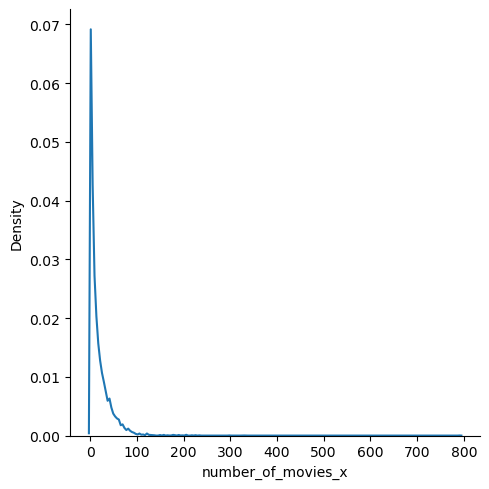

In [44]:
sns.displot(edges_nbr_movies, x="number_of_movies_x", kind="kde")

In [45]:
nbr_movies_homophily = edges_nbr_movies.groupby('actor1_fbid')['same_country'].agg(['mean'])
print('mean =',nbr_movies_homophily.mean(), 'and std =', nbr_movies_homophily.std())
homophily['nbr_of_movies']= {
		'mean': float(nbr_movies_homophily.mean()),
		'std': float(nbr_movies_homophily.std())
	}


mean = mean    0.969777
dtype: float64 and std = mean    0.027068
dtype: float64


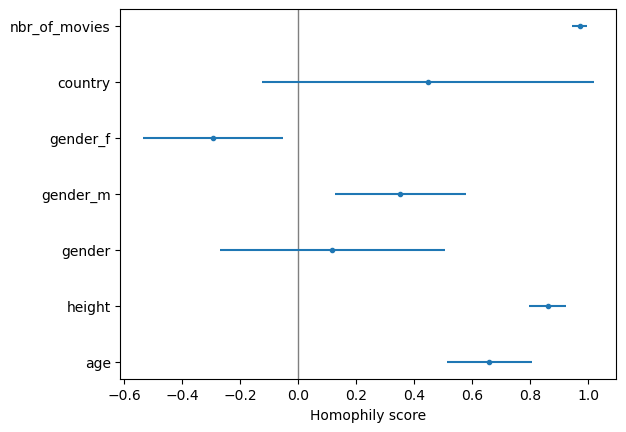

In [46]:
fig, ax = plt.subplots()

ax.axvline(0, color='tab:gray', linewidth=1)
ax.errorbar(
	x=[ a['mean'] for a in homophily.values() ], y=range(len(homophily)),
	xerr=np.array([(a['std']) for a in homophily.values()]).T,
	linestyle='', marker='.'
)
ax.set_yticks(range(len(homophily)))
ax.set_yticklabels([ key for key, values in homophily.items() ])
plt.xlabel("Homophily score")

plt.show()

In [47]:
import seaborn as sns

In [190]:
df_visu = pd.DataFrame({'values':gender_homophily['mean']})
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_m['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':gender_homophily_f['mean']})])
df_visu= pd.concat([df_visu, pd.DataFrame({'values':country_homophily['mean']})])
df_visu


,values
actor1_fbid,
/m/010p3,0.359223
/m/010q36,0.600000
/m/010xjr,0.448931
/m/0112yl,0.435897
/m/011_24,0.391304
...,...
/m/0z05l,-0.437500
/m/0z4s,-0.013774
/m/0z9q0,-1.000000


In [191]:
df_visu2 = pd.DataFrame({'values':age_homophily['mean']})
df_visu2= pd.concat([df_visu2, pd.DataFrame({'values':height_homophily['mean']})])
df_visu2= pd.concat([df_visu2, pd.DataFrame({'values':nbr_movies_homophily['mean']})])

In [192]:
range_idx = [len(gender_homophily),len(gender_homophily_m),len(gender_homophily_f),len(country_homophily)]
name = ['gender','gender_m','gender_f','country']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)

In [193]:
df_visu['name']= idx
df_visu= df_visu.reset_index(drop=True)
df_visu

,values,name
0,0.359223,gender
1,0.600000,gender
2,0.448931,gender
3,0.435897,gender
4,0.391304,gender
...,...,...
137108,-0.437500,country
137109,-0.013774,country
137110,-1.000000,country
137111,0.898305,country


In [194]:
range_idx = [len(age_homophily),len(height_homophily),len(nbr_movies_homophily)]
name = ['age','height','nbr_movies_played']
idx= []
for i, name in zip(range_idx, name):
    for j in range(i):
        idx.append(name)

In [195]:
df_visu2['name']= idx
df_visu2= df_visu2.reset_index(drop=True)
df_visu2 = df_visu2[df_visu2['values']> 0]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/s

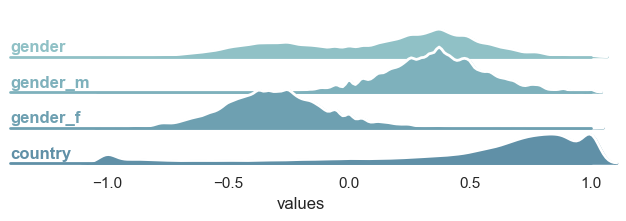

In [196]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(-1.4, 1))



/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/s

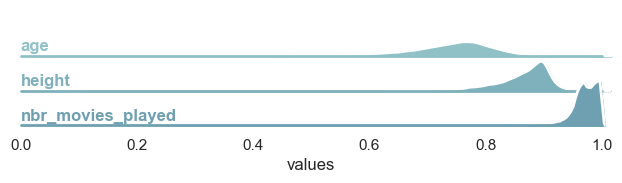

In [197]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_visu2, row="name", hue="name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "values",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "values", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "values")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(0, 1))



## Comparison with "mean actor" of the dataset

> first : try to calculate the homophily score if actors are linked to each others

In [87]:
df_gender_reduced = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')
nbr_of_men = len(df_gender_reduced[df_gender_reduced['actor_gender_x'] == 'M'])
nbr_of_women = len(df_gender_reduced) - nbr_of_men
hypothetical_gender_homophily_score = (nbr_of_men*((nbr_of_men-1)+ (-1)*nbr_of_women))/(len(df_gender_reduced)-1) + (nbr_of_women*((nbr_of_women-1)+ (-1)*nbr_of_men))/(len(df_gender_reduced)-1)
hypothetical_gender_homophily= hypothetical_gender_homophily_score/len(df_gender_reduced)
hypothetical_gender_homophily


0.07556350154453101

In [88]:
df_edges_nat_reduced = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
xy = df_edges_nat_reduced.groupby('actor_nationality_x')['actor1_fbid'].agg(['count'])
total_actor= xy.sum()
homophily_score=0
for i in xy.iloc:
    homophily_score+= (int(i)*(int(i)-1)+(-1)*(total_actor-int(i)))/(total_actor-1)
hypo_homophily_country = homophily_score/total_actor
hypo_homophily_country

count    0.213222
dtype: float64

> second proposition : create a mean actor of the dataset and link him to each actor to compute the homophily score

In [171]:
df_actor_with_nat = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')[['actor1_fbid','actor_nationality_x']]
df_nat = df_edges_nat.drop_duplicates(subset= 'actor1_fbid')
nbr_per_country = df_nat.groupby('actor_nationality_x')['actor1_fbid'].agg(['count'])
probabilties = pd.DataFrame({'country': list(nbr_per_country.index),'probability': list(nbr_per_country['count'].apply(lambda x: x/nbr_per_country.sum())['count'])})
probabilties


,country,probability
0,Albania,0.000084
1,Algeria,0.000141
2,Argentina,0.006392
3,Armenia,0.000028
4,Australia,0.019908
...,...,...
143,Weimar Republic,0.000141
144,West Bengal,0.000028
145,West Germany,0.000056
146,Yugoslavia,0.000084


In [295]:
l =[]
for i in df_actor_with_nat.actor_nationality_x:
    l.append(float(probabilties[probabilties['country']== i].probability -(1-probabilties[probabilties['country']== i].probability)))
l
df_actor_with_nat['homophily_nat_mean_actor']= l

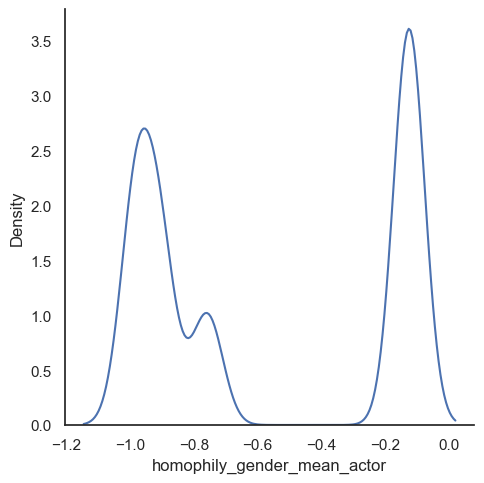

In [173]:
sns.displot(df_actor_with_nat, x="homophily_nat_mean_actor", kind="kde")

In [296]:
df_visu_compare= pd.DataFrame({"homophily score nationalities":country_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score nationalities":df_actor_with_nat['homophily_nat_mean_actor']})])
range_idx = [len(country_homophily),len(df_actor_with_nat)]
names = ['true edges','edges with mean actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)


In [297]:
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)
df_visu_compare

,homophily score nationalities,subset
0,0.761905,true edges
1,0.600000,true edges
2,-0.923077,true edges
3,0.065421,true edges
4,0.593103,true edges
...,...,...
71009,-0.993242,edges with mean actor
71010,-0.124996,edges with mean actor
71011,-0.997747,edges with mean actor
71012,-0.124996,edges with mean actor


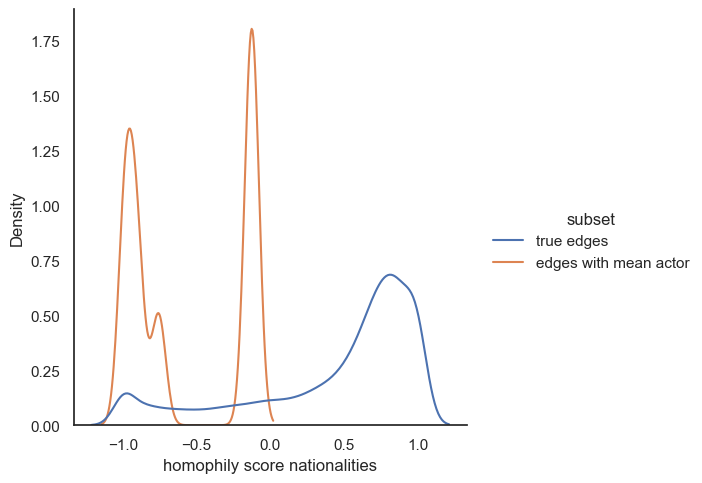

In [298]:
sns.displot(data=df_visu_compare, x="homophily score nationalities", hue="subset", kind="kde")

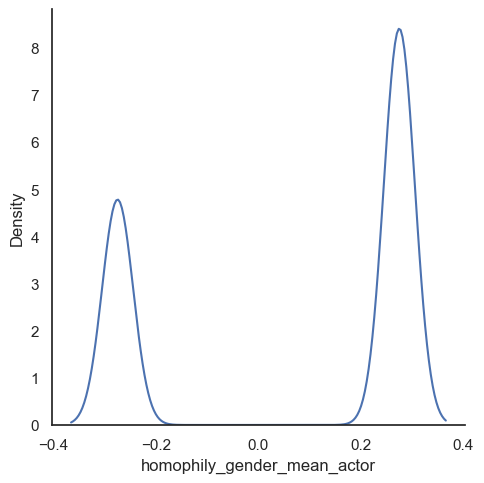

In [170]:
df_actor_with_gender = df_edges_gender.drop_duplicates(subset= 'actor1_fbid')[['actor1_fbid','actor_gender_x']]
nbr_per_gender = df_edges_gender.drop_duplicates(subset= 'actor1_fbid').groupby('actor_gender_x')['actor1_fbid'].agg(['count'])
probabilties = pd.DataFrame({'country': list(nbr_per_gender.index),'probability': list(nbr_per_gender['count'].apply(lambda x: x/nbr_per_gender.sum())['count'])})
l =[]
for i in df_actor_with_gender.actor_gender_x:
    l.append(float(probabilties[probabilties['country']== i].probability -(1-probabilties[probabilties['country']== i].probability)))
l
df_actor_with_gender['homophily_gender_mean_actor']= l
sns.displot(df_actor_with_gender, x="homophily_gender_mean_actor", kind="kde")

In [281]:
df_actor_with_gender

,actor1_fbid,actor_gender_x,homophily_gender_mean_actor
0,/m/02cvp8,M,0.274921
1,/m/026xmsr,M,0.274921
2,/m/02z023s,M,0.274921
3,/m/030dx5,M,0.274921
4,/m/03gsgd9,M,0.274921
...,...,...,...
3418329,/m/0c1gv5t,M,0.274921
3418330,/m/0c1gv68,M,0.274921
3418332,/m/0g4tryj,F,-0.274921
3418350,/m/0c1gv65,F,-0.274921


In [283]:
df_visu_compare= pd.DataFrame({"homophily score gender":gender_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score gender":df_actor_with_gender['homophily_gender_mean_actor'][0:int(len(df_actor_with_gender)/4)]})])
range_idx = [len(gender_homophily),int(len(df_actor_with_gender)/4)]
names = ['true edges','edges with mean actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)

/var/folders/ds/cj908hnj5zq16fhjrglmxkrw0000gn/T/ipykernel_1000/500941060.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score gender":df_actor_with_gender['homophily_gender_mean_actor'][0:int(len(df_actor_with_gender)/4)]})])


In [284]:
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)


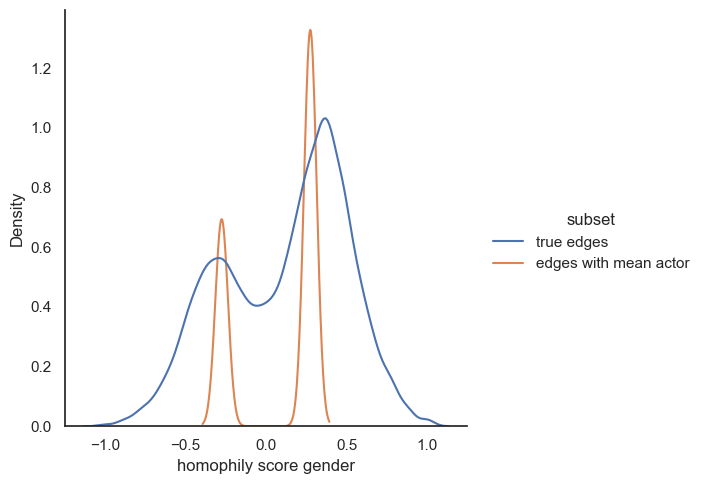

In [285]:
sns.displot(data=df_visu_compare, x="homophily score gender", hue="subset", kind="kde")

,actor1_fbid,actor2_fbid,movie_count,actor_age_x,actor_name_x,ethnicity_x,actor_height_x,actor_gender_x,actor_nationality_x,year_of_birth_x,...,number_of_movies_x,actor_age_y,actor_name_y,ethnicity_y,actor_height_y,actor_gender_y,actor_nationality_y,year_of_birth_y,actor_degree_y,number_of_movies_y
0,/m/02cvp8,/m/02t0n9,219,NaN,Moe Howard,NaN,1.620,M,United States of America,1897,...,225,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
1,/m/026xmsr,/m/02t0n9,72,NaN,Vernon Dent,NaN,NaN,M,United States of America,1895,...,80,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
2,/m/02z023s,/m/02t0n9,40,NaN,Bud Jamison,NaN,NaN,M,United States of America,1894,...,58,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
3,/m/030dx5,/m/02t0n9,82,NaN,Samuel Howard,NaN,1.651,M,United States of America,1895,...,97,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
4,/m/03gsgd9,/m/02t0n9,23,NaN,Eddie Laughton,NaN,NaN,M,United Kingdom,1903,...,26,55.0,Larry Fine,NaN,1.6256,M,United States of America,1902,357,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036589,/m/0crc1n7,/m/02y_r9n,3,28.0,S. Shamsuddin,NaN,NaN,M,Singapore,1929,...,5,60.0,Aziz Sattar,NaN,NaN,M,Malaysia,1925,17,7
3036590,/m/02f27,/m/0gcb2b4,1,61.0,Dirk Benedict,NaN,1.800,M,United States of America,1945,...,16,NaN,Eike Becker,NaN,NaN,M,NaN,<NA>,19,2
3036591,/m/03qp512,/m/02pyhqk,1,27.0,Peter Lee Lawrence,NaN,NaN,M,West Germany,1945,...,5,29.0,Steve Sipek,NaN,NaN,M,Canada,1942,16,2
3036592,/m/03cx_n5,/m/0gc6ycx,1,NaN,Joel Hoffman,NaN,NaN,M,NaN,<NA>,...,3,NaN,Courtney Lercara,NaN,NaN,F,NaN,<NA>,18,2


In [262]:
from random import sample
df_edges_random = df_edges.copy()
df_edges_random['actor2_fbid']= sample(list(df_edges['actor2_fbid']),len(df_edges))

In [263]:
df_edges_random

,actor1_fbid,actor2_fbid,movie_count
503641,/m/02cvp8,/m/02tqys,219
503751,/m/02cvp8,/m/03gh1d_,119
655469,/m/02t0n9,/m/05l0j5,119
906958,/m/03mv0b,/m/0337zp,101
503672,/m/02cvp8,/m/0gbzv_x,82
...,...,...,...
717944,/m/09t0l3,/m/04_b_54,1
717943,/m/09rxk8z,/m/026myr,1
717942,/m/09rvxt5,/m/0dfg4h,1
717941,/m/09q3gc,/m/057crf,1


In [264]:
x=df_edges_random.merge(df_actors_reduced, on='actor1_fbid')
df_actors_reduced=df_actors_reduced.rename(columns={"actor1_fbid": "actor2_fbid"})
df_edges_merged_random= x.merge(df_actors_reduced, on='actor2_fbid')

In [265]:
df_edges_gender_rdm=df_edges_merged_random.dropna(subset=['actor_gender_x'])
df_edges_gender_rdm=df_edges_gender_rdm.dropna(subset=['actor_gender_y'])

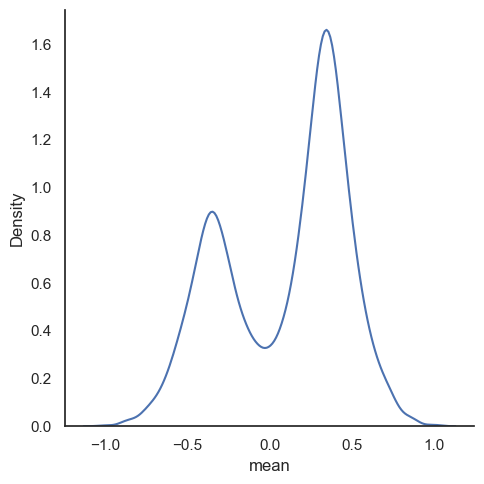

In [266]:
df_edges_gender_rdm['same_gender'] = df_edges_gender_rdm.apply(lambda x: 1 if (x.actor_gender_x == x.actor_gender_y) else (-1), axis= 1)
gender_homophily_rdm = df_edges_gender_rdm.groupby('actor1_fbid')['same_gender'].agg(['mean'])
sns.displot(gender_homophily_rdm, x="mean", kind="kde")

Text(0.5, 1.0, 'Kernel Density Function')

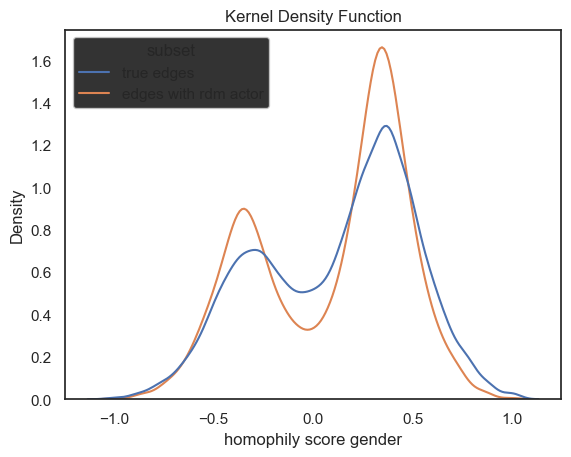

In [268]:
df_visu_compare= pd.DataFrame({"homophily score gender":gender_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score gender":gender_homophily_rdm['mean']})])
range_idx = [len(gender_homophily),len(gender_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)
sns.kdeplot(x='homophily score gender', data=df_visu_compare, hue='subset', common_norm=False);
plt.title("Kernel Density Function")

In [272]:
from scipy.stats import ttest_ind
stat, p_value = ttest_ind(gender_homophily,gender_homophily_rdm)
p_value

array([1.78340728e-22])

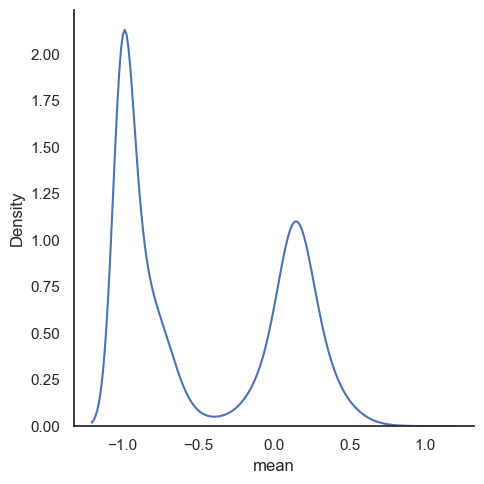

In [286]:
df_edges_gender_rdm=df_edges_merged_random.dropna(subset=['actor_nationality_x'])
df_edges_gender_rdm=df_edges_gender_rdm.dropna(subset=['actor_nationality_y'])
df_edges_gender_rdm['same_nat'] = df_edges_gender_rdm.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
gender_homophily_rdm = df_edges_gender_rdm.groupby('actor1_fbid')['same_nat'].agg(['mean'])
sns.displot(gender_homophily_rdm, x="mean", kind="kde")

Text(0.5, 1.0, 'Kernel Density Function')

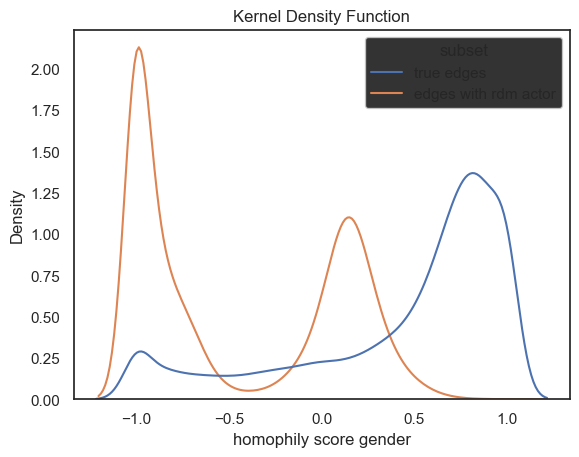

In [299]:
df_visu_compare= pd.DataFrame({"homophily score gender":country_homophily['mean']})
df_visu_compare= pd.concat([df_visu_compare, pd.DataFrame({"homophily score gender":gender_homophily_rdm['mean']})])
range_idx = [len(country_homophily),len(gender_homophily_rdm)]
names = ['true edges','edges with rdm actor']
idx= []
for i, name in zip(range_idx, names):
    for j in range(i):
        idx.append(name)
df_visu_compare['subset']= idx
df_visu_compare= df_visu_compare.reset_index(drop=True)
sns.kdeplot(x='homophily score gender', data=df_visu_compare, hue='subset', common_norm=False);
plt.title("Kernel Density Function")

## Study on the country feature over the decades

In [61]:
edges_country=df_edges.dropna(subset=['actor_nationality_x'])
edges_country= edges_country.dropna(subset=['actor_nationality_y'])
edges_country= edges_country.dropna(subset=['year_of_birth_x'])
homophily_country = {}

for i in range(13):
    country_per_decade = edges_country[edges_country['year_of_birth_x'] > (1900+i*10)]
    country_per_decade = country_per_decade[country_per_decade['year_of_birth_x'] < (1910+i*10)]
    country_per_decade['same_country'] = country_per_decade.apply(lambda x: 1 if (x.actor_nationality_x == x.actor_nationality_y) else (-1), axis= 1)
    country_homophily = country_per_decade.groupby('actor1_fbid')['same_country'].agg(['mean'])
    homophily_country['decade'+str(i)]= {
		'mean': float(country_homophily.mean()),
		'std': float(country_homophily.std())
	}

In [283]:
del homophily_country["decade11"]
del homophily_country["decade12"]

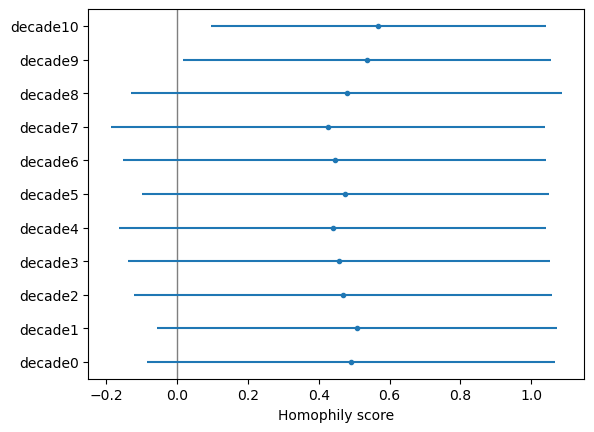

In [285]:
fig, ax = plt.subplots()

ax.axvline(0, color='tab:gray', linewidth=1)
ax.errorbar(
	x=[ a['mean'] for a in homophily_country.values() ], y=range(len(homophily_country)),
	xerr=np.array([(a['std']) for a in homophily_country.values()]).T,
	linestyle='', marker='.'
)
ax.set_yticks(range(len(homophily_country)))
ax.set_yticklabels([ key for key, values in homophily_country.items() ])
plt.xlabel("Homophily score")

plt.show()

In [41]:
import networkx as nx

In [116]:
df_edges_nat.drop_duplicates(subset= 'actor1_fbid').groupby('actor_nationality_x')['actor_nationality_x'].agg(['count']).sort_values(by='count', ascending= False).head(10)

,count
actor_nationality_x,
United States of America,6796
United Kingdom,1412
Canada,515
India,384
Japan,230
Australia,204
South Korea,178
Germany,138
France,137


In [84]:
df_edges_grouped= df_edges_red[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 36117 nodes and 800828 edges


In [85]:
x = edges_gender.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_gender_x']))
nx.set_node_attributes(g, name = "actor_gender_x", 
values = class_attr)

In [86]:
nx.attribute_assortativity_coefficient(g, "actor_gender_x")

0.016975559634246747

In [87]:
df_edges_grouped= df_edges_red[['actor1_fbid','actor2_fbid','movie_count']]
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 36117 nodes and 800828 edges


In [88]:
x = edges_country.drop_duplicates(subset= 'actor1_fbid')
class_attr = dict(zip(x['actor1_fbid'], 
x['actor_nationality_x']))
nx.set_node_attributes(g, name = "actor_nationality_x", 
values = class_attr)

In [89]:
nx.attribute_assortativity_coefficient(g, "actor_nationality_x")

0.5615287619615378

In [326]:
test= df_edges_nat.drop_duplicates(subset= "actor1_fbid").groupby('actor_nationality_x')['actor2_fbid'].agg(['count'])
test['country']= test.index
test= test.reset_index(drop= True)
test

,count,country
0,3,Albania
1,5,Algeria
2,227,Argentina
3,1,Armenia
4,707,Australia
...,...,...
142,5,Weimar Republic
143,1,West Bengal
144,2,West Germany
145,3,Yugoslavia


In [301]:
import plotly.graph_objs as go

In [327]:
choropleth_map = go.Figure(
    data = {
        'type':'choropleth',
        'locations':test['country'],
        'locationmode':'country names',
        'colorscale':'Portland',
        'z':test['count'],
        'colorbar':{'title':'World Population in 2020'},
        'marker': {
            'line': {
                'color':'rgb(255,255,255)',
                'width':2
            }
        }
    },     
    layout = {      
      'geo':{
          'scope':'world', 
      }  
    })
choropleth_map

In [335]:
test =pd.DataFrame(test)

In [344]:
choropleth_map = go.Figure(
    data = {
        'type':'choropleth',
        'locations':test['country'],
        'locationmode':'country names',
        'colorscale':'Portland',
        'z':test['count'],
        'colorbar':{'title':'World Population in 2020'},
        'marker': {
            'line': {
                'color':'rgb(255,255,255)',
                'width':2
            }
        }
    },     
)

choropleth_map.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    width=900,
    height=600,
    title='World Map with number of actors per country'
)